In [10]:
import os

import numpy as np
import skimage.io as io
import scipy.signal as signal
import matplotlib.pyplot as plt

os.chdir('/home/chris/Documents/2_semester/03_adv_img_analysis/')

# Image convolution

In [11]:
def get_gaussian_kernel(sigma: float, kernel_size: int=None) -> np.ndarray:

    if kernel_size is None:
        kernel_size = int(4 * sigma)

    t = sigma**2
    x = np.arange(-kernel_size, kernel_size+1, 1)

    kernel = np.exp(- x**2 / (2 * t)) / np.sqrt(2 * t * np.pi)

    return kernel / np.sum(kernel)


def get_gaussian_derivative_kernel(sigma: float, kernel_size: int=None) -> np.ndarray:

    if kernel_size is None:
        kernel_size = int(4 * sigma)

    t = sigma**2
    x = np.arange(-kernel_size, kernel_size+1, 1)

    kernel = - x * np.exp(- x**2 / (2 * sigma**2)) / (sigma**3 * np.sqrt(2 * np.pi))

    return kernel / np.sum(kernel)

In [12]:
kernel_1d = get_gaussian_kernel(4.5)
# kernel_1d = get_gaussian_kernel(10)
kernel_2d = np.outer(kernel_1d, kernel_1d)

test_img = io.imread('adv_img_analysis_notes/data/week1/fibres_xcth.png', as_gray=True)
# test_img = io.imread('adv_img_analysis_notes/data/week1/noisy_number_2023.png', as_gray=True)
img2 = signal.convolve2d(test_img, kernel_2d, mode='same')
img3 = signal.convolve2d(test_img, kernel_1d[:, None], mode='same')
img3 = signal.convolve2d(img3, kernel_1d[:, None].T, mode='same')

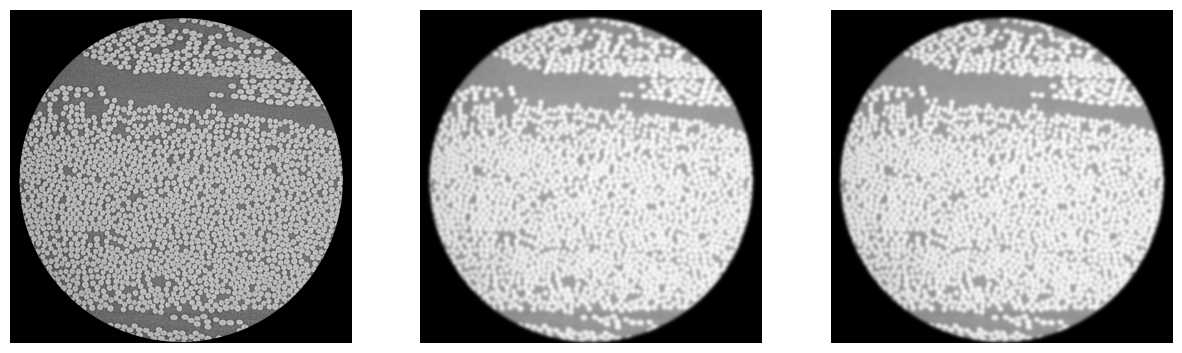

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax, img in zip(axs, [test_img, img2, img3]):
# for ax, img in zip(axs, [test_img, img2]):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.show()


-2.473825588822365e-10 2.473825588822365e-10


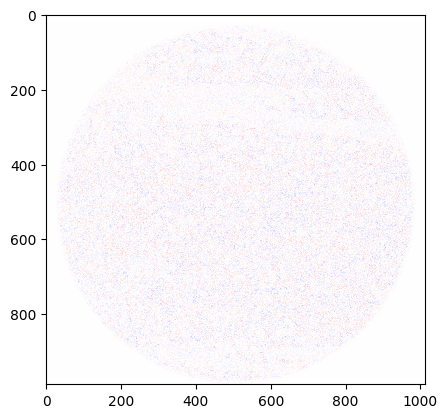

In [14]:
diff = img2 - img3
print(diff.min(), diff.max())
plt.imshow(diff, cmap='bwr')
plt.show()

-2.0182415008830933e+21 2.0182878555874043e+21


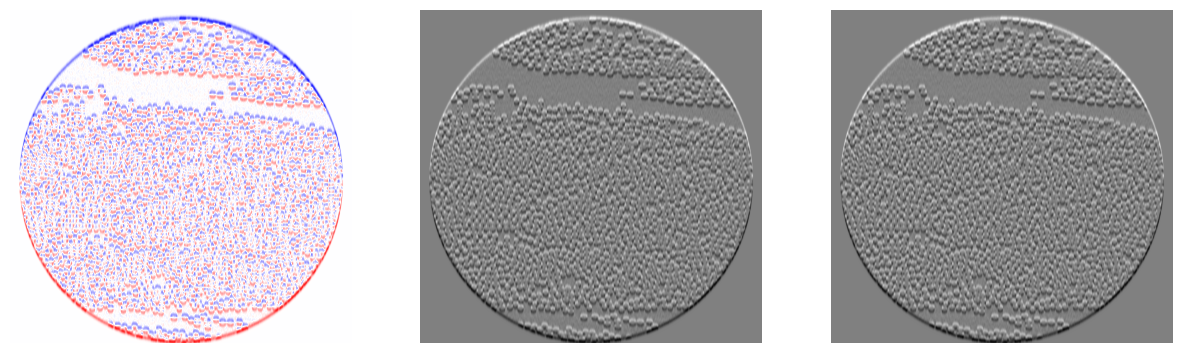

In [15]:
diff_kernel = np.array([0.5, 0, -0.5])

diff_img = signal.convolve2d(test_img, diff_kernel[:, None], mode='same')
diff_img2 = signal.convolve2d(diff_img, kernel_1d[:, None], mode='same')
diff_img3 = signal.convolve2d(test_img, get_gaussian_derivative_kernel(4.5)[:, None], mode='same')

diff = diff_img2 - diff_img3

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
print(diff.min(), diff.max())

axs[0].imshow(diff, cmap='bwr')
axs[1].imshow(diff_img2, cmap='gray')
axs[2].imshow(diff_img3, cmap='gray')

for ax, img in zip(axs, [diff, diff_img2, diff_img3]):
    ax.axis('off')

plt.show()


# Length of segmentation boundaries

In [17]:
from PIL import Image

img1 = np.array(Image.open('adv_img_analysis_notes/data/week1/fuel_cells/fuel_cell_1.tif'))
img2 = np.array(Image.open('adv_img_analysis_notes/data/week1/fuel_cells/fuel_cell_2.tif'))
img3 = np.array(Image.open('adv_img_analysis_notes/data/week1/fuel_cells/fuel_cell_3.tif'))



In [22]:
def get_segmentation_boundary(img: np.ndarray) -> np.ndarray:

    diff_horizontal = (img[1:, :] != img[:-1, :])[:, :-1]
    diff_vertical = (img[:, 1:] != img[:, :-1])[:-1, :]

    return diff_horizontal | diff_vertical


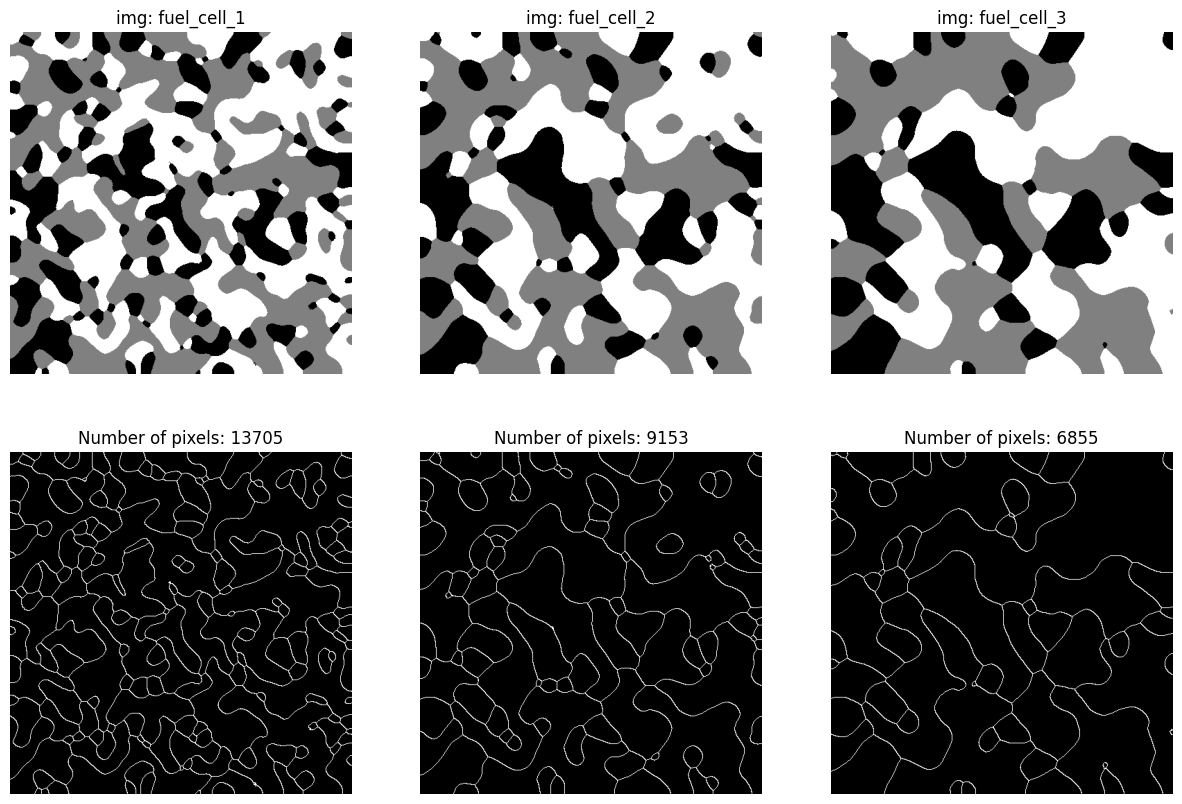

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for idx, (ax, img) in enumerate(zip(axs.T, [img1, img2, img3]), start=1):
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(f'img: fuel_cell_{idx}')
    boundery = get_segmentation_boundary(img)
    ax[1].imshow(boundery, cmap='gray')
    ax[1].set_title(f'Number of pixels: {boundery.sum()}')
    ax[0].axis('off')
    ax[1].axis('off')

plt.show()


# Curve smoothing

In [25]:
import scipy

In [27]:
dino = np.loadtxt('adv_img_analysis_notes/data/week1/curves/dino_noisy.txt')


In [31]:
def simple_smooth_curve(curve: np.ndarray, _lambda: float) -> np.ndarray:

    N, _ = curve.shape
    L = np.zeros(N)
    L[0] = -2
    L[1] = L[-1] = 1

    L = scipy.linalg.circulant(_lambda * L)

    return (np.eye(N) + L) @ curve


def smooth_curve(curve: np.ndarray, alpha: float, beta: float) -> np.ndarray:

    N, _ = curve.shape
    A = np.zeros(N)
    A[0] = -2
    A[1] = A[-1] = 1

    B = np.zeros(N)
    B[0] = -6
    B[1] = B[-1] = 4
    B[2] = B[-2] = -1

    L = scipy.linalg.circulant(alpha * A + beta * B)

    return np.linalg.solve(np.eye(N) - L, curve)


In [56]:
def get_curve_length(curve: np.ndarray) -> float:

    if np.all(curve[0] != curve[-1]):
        curve = np.vstack([curve, curve[0]])

    return np.sum(np.linalg.norm(curve[1:] - curve[:-1], axis=1))

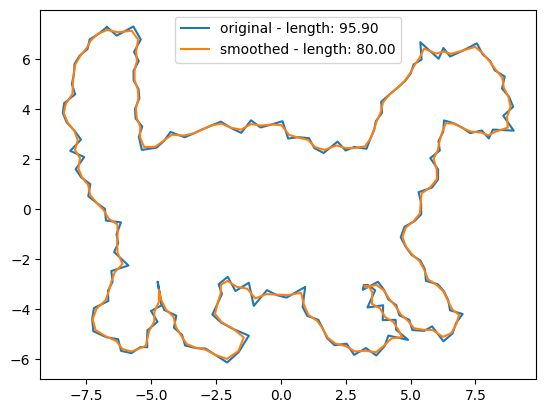

In [60]:
dino_new = simple_smooth_curve(dino, 0.19)

dino_fig_old = np.vstack([dino, dino[0]])
dino_fig_new = np.vstack([dino_new, dino_new[0]])

plt.plot(*dino_fig_old.T, label=f'original - length: {get_curve_length(dino_fig_old):.2f}')
plt.plot(*dino_fig_new.T, label=f'smoothed - length: {get_curve_length(dino_fig_new):.2f}')
plt.legend()

plt.show()



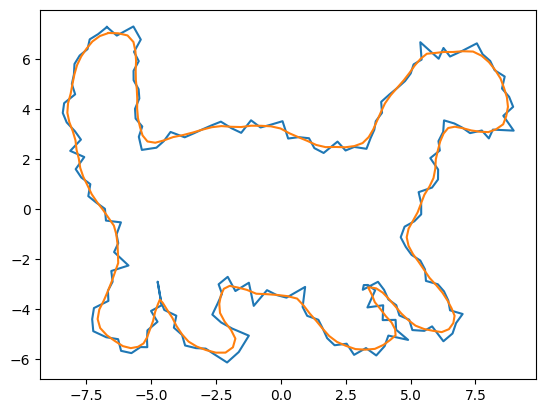

In [34]:
dino_new = smooth_curve(dino, 1, 1)

plt.plot(*np.concatenate((dino, dino[0, None]), 0).T)
plt.plot(*np.concatenate((dino_new, dino_new[0, None]), 0).T)

plt.show()